<a href="https://colab.research.google.com/github/guestus/voice_recognition/blob/main/sound_experements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Поставим задачу обучать на классификацию возраста на 6 классов.

- 0 - до 20 лет
- 1 - от 20 до 30
- 2 - от 30 до 40
- 3 - от 40 до 50
- 4 - от 50 до 60
- 5 - старше 60 лет

Учитывая что есть различия между мужским и женским голосом, то добавим классификацию по полу.
- 0 - женщины до 20 лет
- 1 - женщины от 20 до 30
- 2 - женщины от 30 до 40
- 3 - женщины от 40 до 50
- 4 - женщины от 50 до 60
- 5 - женщины старше 60 лет
- 6 - мужчины до 20 лет
- 7 - мужчины от 20 до 30
- 8 - мужчины от 30 до 40
- 9 - мужчины от 40 до 50
- 10 - мужчины от 50 до 60
- 11 - мужчины старше 60 лет


Обучаться будем на части common-voice  взятой с kaggle

https://kaggle.com/mozillaorg/common-voice


Для ускорения работы мы сделаем предпроцессинг звуковых файлов преобразовав их в mel-спектрограммы и будем использовать дампы pickle подготовленные заранее.


In [ ]:
# pep8 tests
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

     |████████████████████████████████| 42 kB 504 kB/s 
Looking in indexes: https://test.pypi.org/simple/


In [ ]:
from nbpep8.nbpep8 import pep8

In [ ]:
!nvidia-smi

Wed Feb  2 17:57:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import time
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchaudio
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from torchsummary import summary
import os
import copy
import pickle

In [ ]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
batch_size = 256
num_epochs = 30
learning_rate = 1e-3
dropout = 0.5
loss_func = nn.SmoothL1Loss  # в дополнение к NLLLoss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Datasets part

In [ ]:
# Загрузка датасета с каггла. Необходим файл api kaggle.json
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mozillaorg/common-voice
! mkdir ./cv
! unzip -q ./common-voice.zip -d ./cv/
! mkdir ./cv-composed
! mkdir ./cv-composed/clips

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 12.0G/12.0G [05:19<00:00, 26.6MB/s]
100% 12.0G/12.0G [05:19<00:00, 40.5MB/s]


In [ ]:
# ! mkdir ./cv
# ! unzip -q ./common-voice.zip -d ./cv/


In [ ]:
# подготовка данных, выборка только голосов с возрастом и полом
from shutil import copy
from tqdm import tqdm
import numpy as np
import random
import torchaudio

with open('./cv-composed/train.tsv', 'w') as wf:
    with open('./cv/cv-valid-train.csv', 'r') as f:
        header = f.readline()
        header = "client_id\tpath\tsentence\tup_votes\tdown_votes\tage\t" \
                  +"gender\taccent\tlocale\tsegment"
        wf.write(header)
        for line in tqdm(f):
            line_sp = line[:-1].split(',')
            if line_sp[4] and line_sp[5] in ['male', 'female']:
                filename = line_sp[0]
                new_filename = 'train-' + filename.split('/')[1]
                line_sp.insert(0, '-')
                line_sp[1] = new_filename
                # line_sp.append('')
                new_line = '\t'.join(line_sp) + '\t\n'
                wf.write(new_line)
                copy(
                    './cv/cv-valid-train/' +
                    filename,
                    './cv-composed/clips/' +
                    new_filename)
with open('./cv-composed/val.tsv', 'w') as wf:
    with open('./cv/cv-valid-dev.csv', 'r') as f:
        header = f.readline()
        header = "client_id\tpath\tsentence\tup_votes\tdown_votes\t" \
                 +"age\tgender\taccent\tlocale\tsegment"
        wf.write(header)
        for line in tqdm(f):
            line_sp = line[:-1].split(',')
            # print(cur_spk)
            if line_sp[4] and line_sp[5] in ['male', 'female']:
                filename = line_sp[0]
                new_filename = 'val-' + filename.split('/')[1]
                line_sp.insert(0, '-')
                line_sp[1] = new_filename
                new_line = '\t'.join(line_sp) + '\t\n'
                wf.write(new_line)
                copy(
                    './cv/cv-valid-dev/' +
                    filename,
                    './cv-composed/clips/' +
                    new_filename)

with open('./cv-composed/test.tsv', 'w') as wf:
    with open('./cv/cv-valid-test.csv', 'r') as f:
        header = f.readline()
        header = "client_id\tpath\tsentence\tup_votes\tdown_votes" \
                  +"\tage\tgender\taccent\tlocale\tsegment"
        wf.write(header)
        for line in tqdm(f):
            line_sp = line[:-1].split(',')
            # print(cur_spk)
            if line_sp[4] and line_sp[5] in ['male', 'female']:
                filename = line_sp[0]
                new_filename = 'test-' + filename.split('/')[1]
                line_sp.insert(0, '-')
                line_sp[1] = new_filename
                new_line = '\t'.join(line_sp) + '\t\n'
                wf.write(new_line)
                copy(
                    './cv/cv-valid-test/' +
                    filename,
                    './cv-composed/clips/' +
                    new_filename)


pep8(_ih)                

195776it [00:27, 7123.73it/s] 
4076it [00:00, 6077.65it/s]
3995it [00:00, 5850.50it/s]


In [ ]:
# преобразуем звуковые файлы в мел-спектрограммы
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchaudio
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from torchsummary import summary
import os
import copy
import pickle


cv_train_ds = torchaudio.datasets.COMMONVOICE(
    root='./cv-composed/', tsv='train.tsv')
cv_val_ds = torchaudio.datasets.COMMONVOICE(
    root='./cv-composed/', tsv='val.tsv')
cv_test_ds = torchaudio.datasets.COMMONVOICE(
    root='./cv-composed/', tsv='test.tsv')
cv_ds = {'train': cv_train_ds, 'val': cv_val_ds, 'test': cv_test_ds}

n_class = 6

def age2class(age):
    if age < 19:
        lbl = 0
    if 19 <= age < 30:
        lbl = 1
    if 30 <= age < 40:
        lbl = 2
    if 40 <= age < 50:
        lbl = 3
    if 50 <= age < 60:
        lbl = 4
    if age >= 60:
        lbl = 5
    return lbl


cv_age2class = dict({'teens': 0,
                     'twenties': 1,
                     'thirties': 2,
                     'fourties': 3,
                     'fifties': 4,
                     'sixties': 5,
                     'seventies': 5,
                     'eighties': 5,
                     'nineties': 5})
cv_ages_classes = [
    'F<19',
    'F-twenties',
    'F-thirties',
    'F-fourties',
    'F-fifties',
    'F >50',
    'M<19',
    'M-twenties',
    'M-thirties',
    'M-fourties',
    'M-fifties',
    'M >50']


class SoundData():

    def __init__(self, max_feature_width=256, features='mel'):
        super(SoundData, self).__init__()
        self.features_extractor = features
        self.max_feature_width = max_feature_width

        self.n_mels = 64
        self.sr = 16000  # torchaudio.load(self.names['test'][0][0])
        self.names = {'train': [],
                      'val': [],
                      'test': []}

        self.getFeatures(mode=self.features_extractor)

    def getFeatures(self, mode='mel'):
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sr,  # 16000
            n_fft=1024,  # 8129
            win_length=1024,
            hop_length=1000,
            n_mels=self.n_mels,
            power=1,
            f_max=8192,
            norm='slaney',
            # onesided=True,
            normalized=False,
            mel_scale="slaney"
        )
        self.mel_delta = torchaudio.transforms.ComputeDeltas()

        self.mels = dict()
        self.mels_length = dict()
        self.labels = dict()
        self.gender = dict()

        for x in ['train', 'val', 'test']:
            additional_dataset_len = len(cv_ds[x])
            self.mels_length[x] = np.ndarray(
                (additional_dataset_len + len(self.names[x])))
            self.mels[x] = torch.zeros(
                (additional_dataset_len + len(
                    self.names[x]),
                    3,
                    self.n_mels,
                    self.max_feature_width),
                dtype=torch.float32)

            self.labels[x] = []
            self.gender[x] = []

            delta_i = len(self.names['train'])
            resample = torchaudio.transforms.Resample(
                orig_freq=48000, new_freq=16000)
            for i, data in enumerate(tqdm(cv_ds[x])):
                # print(data)
                wave = resample(data[0])
                mel = torch.Tensor(self.mel_transform(wave))[0]
                self.mels_length[x][i +
                                    delta_i] = min(self.max_feature_width, mel.shape[1])
                self.mels[x][i + delta_i][0] = torch.nn.functional.pad(
                    mel[:, :self.max_feature_width], (0, max(0, self.max_feature_width - mel.shape[1]), 0, 0))
                self.mels[x][i +
                             delta_i][1] = self.mel_delta(self.mels[x][i +
                                                                       delta_i][0])
                self.mels[x][i +
                             delta_i][2] = self.mel_delta(self.mels[x][i +
                                                                       delta_i][1])

                self.labels[x].append(cv_age2class[data[2]['age']])
                self.gender[x].append(
                    0 if data[2]['gender'] == 'female' else 1)


sd = SoundData(max_feature_width=64, features='mel')


torch.save(sd.mels, '/content/drive/MyDrive/mels2.pt')
torch.save(sd.mels_length, '/content/drive/MyDrive/mels_length2.pt')
with open('/content/drive/MyDrive/labels2.pickle', 'wb') as f:
    pickle.dump(sd.labels, f)
with open('/content/drive/MyDrive/gender2.pickle', 'wb') as f:
    pickle.dump(sd.gender, f)

pep8(_ih)    

100%|██████████| 1522/1522 [00:13<00:00, 114.98it/s]


In [ ]:
n_class = 6


def age2class(age):
    if age < 19:
        lbl = 0
    if 19 <= age < 30:
        lbl = 1
    if 30 <= age < 40:
        lbl = 2
    if 40 <= age < 50:
        lbl = 3
    if 50 <= age < 60:
        lbl = 4
    if age >= 60:
        lbl = 5
    return lbl


cv_age2class = dict({'teens': 0,
                     'twenties': 1,
                     'thirties': 2,
                     'fourties': 3,
                     'fifties': 4,
                     'sixties': 5,
                     'seventies': 5,
                     'eighties': 5,
                     'nineties': 5})


cv_ages_classes = ['F<19', 'F-twenties', 'F-thirties', 'F-fourties',
                   'F-fifties', 'F >60', 'M<19', 'M-twenties', 'M-thirties',
                   'M-fourties', 'M-fifties', 'M >60']
pep8(_ih)

In [ ]:
mels = torch.load('/content/drive/MyDrive/mels2.pt')
mels_length = torch.load('/content/drive/MyDrive/mels_length2.pt')
with open('/content/drive/MyDrive/labels2.pickle', 'rb') as f:
    labels = pickle.load(f)
with open('/content/drive/MyDrive/gender2.pickle', 'rb') as f:
    gender = pickle.load(f)
mels_data = [mels, mels_length, labels, gender]


pep8(_ih)

In [ ]:
class MelDataset(Dataset):
    def __init__(self, mels_data, mode='train'):
        self.md = mels_data
        self.max_width = 64
        self.mode = mode

    def __len__(self):
        return self.md[0][self.mode].shape[0]

    def __getitem__(self, idx):
        win = max(0, (int(self.md[1][self.mode][idx])-self.max_width) // 2)
        if self.mode == 'train':
            win = random.randint(0,
                                 max(0, int(self.md[1]['train'][idx] -
                                            self.max_width)))
        gender = self.md[3][self.mode][idx]
        age = self.md[2][self.mode][idx] + n_class * gender
        mel = self.md[0][self.mode][idx][:, :, win:win + self.max_width]
        return mel, age


pep8(_ih)

In [ ]:
dataloaders_dict = {x: DataLoader(MelDataset(mels_data, x),
                                  batch_size=batch_size,
                                  shuffle=(x == 'train'))
                    for x in ['train', 'val', 'test']}


pep8(_ih)

cell_content.py:5:1: W293 blank line contains whitespace



In [ ]:
print("train - ", len(dataloaders_dict['train'].dataset))
print("val - ", len(dataloaders_dict['val'].dataset))
print("test - ", len(dataloaders_dict['test'].dataset))

train -  72691
val -  1510
test -  1522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


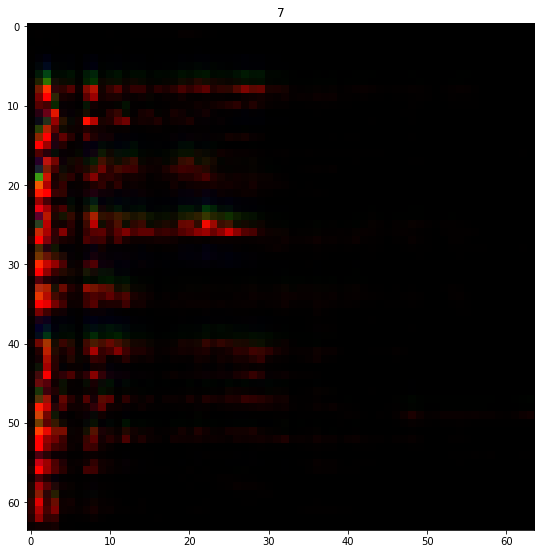

In [ ]:
# Пример окна из набора Train
item = random.randint(0, 100)
plt.figure(figsize=(20, 40))
for i in dataloaders_dict['train']:
    plt.subplot(121)
    plt.title(f'{i[1][item]}')
    plt.imshow(i[0][item].swapaxes(0, 2))
    break

pep8(_ih)

In [ ]:
# Вычислим веса классов
from sklearn.utils.multiclass import unique_labels

age_classes = n_class * 2


labels = torch.Tensor()
for _, lbl in dataloaders_dict['train']:
    labels = torch.cat((labels, lbl))
labels = torch.bincount(labels.int())
print("Train, Кол-во по классам: ", labels)
weights_age = torch.zeros((age_classes), dtype=torch.float32)
all = len(dataloaders_dict['train'].dataset)
for i in range(labels.shape[0]):
    weights_age[i] = (all/(labels.shape[0]*labels[i]))


labels = torch.Tensor()
for _, lbl in dataloaders_dict['val']:
    labels = torch.cat((labels, lbl))
labels = torch.bincount(labels.int())
print("Val, Кол-во по классам: ", labels)
weights_age_val = torch.zeros((age_classes), dtype=torch.float32)
all = len(dataloaders_dict['train'].dataset)
for i in range(labels.shape[0]):
    weights_age_val[i] = (all/(labels.shape[0]*labels[i]))


weights = weights_age


pep8(_ih)

Train, Кол-во по классам:  tensor([ 1060,  3954,  4560,  2187,  4467,  1870,  4249, 18494, 13662,  8684,
         4946,  4558])
Val, Кол-во по классам:  tensor([ 28,  87,  88,  59,  87,  41,  84, 389, 256, 180, 116,  95])



In [ ]:
# Основная идея модели была взята из статьи
# https://www.mdpi.com/1424-8220/21/17/5892/pdf
from torch.nn.modules.batchnorm import BatchNorm1d


class ModelSp(nn.Module):
    def __init__(self, n_classes=6, dropout=0.25, hl=120):
        super(ModelSp, self).__init__()
        self.log_vars = nn.Parameter(torch.zeros((2))) # Для Loss
        self.n_classes = n_classes
        self.hl = hl
        flb1 = [
            nn.Conv2d(3, 120, kernel_size=9, stride=2, padding=4),
            nn.ReLU(),
            nn.BatchNorm2d(120),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(120, 256, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(384),
        ]
        flb2 = [
            nn.Conv2d(512, 384, kernel_size=4, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(384, 384, kernel_size=4, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(384),
        ]
        self.flb1 = nn.Sequential(*flb1)
        self.flb2 = nn.Sequential(*flb2)
        self.ta_layer = nn.Sequential(*[
            nn.Conv2d(384, 64, kernel_size=(1, 9), stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(1, 3), stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(1, 3), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ])
        self.fa_layer = nn.Sequential(*[
            nn.Conv2d(384, 64, kernel_size=(9, 1), stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 1), stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 1), stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ])
        self.bn_layer = nn.BatchNorm2d(128)
        self.fc_layer = nn.Sequential(*[
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(384, self.hl),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(self.hl, n_classes * 2),
            nn.LogSoftmax(dim=1)
        ])

    def forward(self, x, debug=False):
        y = self.flb1(x)
        if debug:
            print('flb = ', y.shape)
        ta = self.ta_layer(y)
        if debug:
            print('ta = ', ta.shape)
        fa = self.fa_layer(y)
        if debug:
            print('fa = ', fa.shape)
        con = self.bn_layer(torch.concat((ta, fa), dim=1))
        sk = torch.concat((y, con), dim=1)
        if debug:
            print('sk = ', sk.shape)
        y = self.flb2(sk)
        if debug:
            print('y = ', y.shape)
        age_pred = self.fc_layer(y)
        return age_pred


m = ModelSp()
i = torch.zeros((2, 3, 64, 64))
y = m(i, debug=True)
print(y)

pep8(_ih)

flb =  torch.Size([2, 384, 8, 8])
ta =  torch.Size([2, 64, 8, 8])
fa =  torch.Size([2, 64, 8, 8])
sk =  torch.Size([2, 512, 8, 8])
y =  torch.Size([2, 384, 1, 1])
tensor([[-2.4657, -2.5418, -2.4913, -2.3996, -2.4526, -2.4147, -2.4966, -2.5466,
         -2.5727, -2.4447, -2.4226, -2.5925],
        [-2.4641, -2.5356, -2.4775, -2.3926, -2.4544, -2.4439, -2.4921, -2.5399,
         -2.5737, -2.4471, -2.4350, -2.5820]], grad_fn=<LogSoftmaxBackward0>)



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


In [ ]:
# класс для Loss. Идея взята из 
# https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855
# Параметры log_vars вынесены в модель для работы оптимизации
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, weights, model):
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        # self.log_vars = nn.Parameter(torch.zeros((task_num)))
        self.criterion0 = nn.NLLLoss(weight=weights.to(device))
        self.criterion1 = loss_func()

    def forward(self, preds, age):
        loss0 = self.criterion0(preds, age)

        age_exp = torch.zeros_like(preds)
        age_exp.scatter_(1,  age.unsqueeze(1), 1)
        loss1 = self.criterion1(preds, torch.exp(age_exp))

        precision0 = torch.exp(-self.model.log_vars[0])
        loss0 = precision0*loss0 + self.model.log_vars[0]

        precision1 = torch.exp(-self.model.log_vars[1])
        loss1 = precision1*loss1 + self.model.log_vars[1]

        return loss0+loss1


pep8(_ih)

In [ ]:
# helper functions
def get_perfomance(labels, predicts, eps=1e-10):
    cnf_matrix = confusion_matrix(labels, predicts)
    fp = (cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)).astype(float)
    fn = (cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)).astype(float)
    tp = (np.diag(cnf_matrix)).astype(float)
    tn = (cnf_matrix.sum() - (fp + fn + tp)).astype(float)

    epoch_acc = (tp + tn)/(tp + tn + fp + fn + eps)
    epoch_recall = tp/(tp + fn + eps)
    epoch_prec = tp/(tp + fp + eps)
    epoch_f1 = 2*tp/(2*tp + fp + fn + eps)

    return epoch_acc, epoch_recall, epoch_prec, epoch_f1


pep8(_ih)

In [ ]:
# основа взята с pytorch'а, добавлено что нужно
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                clip=2, scheduler=None):
    wandb.watch(model, criterion, log="all", log_freq=1000)
    since = time.time()
    loss_trn_history = []
    loss_val_history = []
    val_acc_history = []
    val_mae_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_mae = 100.0
    hist_lbl = ['val_acc', 'val_mae', 'loss_trn', 'loss_val']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            epoch_preds = None
            epoch_labels = None
            for X, labels in dataloaders[phase]:
                inputs = X.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.long())
                    preds_age = torch.max(outputs, 1)[1].detach()
                    lbl_age = labels.detach()
                    if epoch_preds is None:
                        epoch_preds = preds_age
                        epoch_labels = lbl_age
                    else:
                        epoch_preds = torch.cat((epoch_preds, preds_age))
                        epoch_labels = torch.cat((epoch_labels, lbl_age))
                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                       clip)
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            running_corrects = torch.sum(epoch_preds == epoch_labels.data)

            epoch_acc, epoch_recall, epoch_prec, epoch_f1 = get_perfomance(
                epoch_labels.cpu(), epoch_preds.cpu())
            print("epoch_f1= {:s}".format(np.array2string(epoch_f1,
                                          precision=2,
                                          floatmode='fixed')))
            epoch_acc = running_corrects.double()/len(
                dataloaders[phase].dataset)
            epoch_mae = mean_absolute_error(epoch_labels.cpu(),
                                            epoch_preds.cpu())

            print('{} Loss: {:.4f} Acc: {:.4f} MAE: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_mae))
            wandb.log({phase: {"loss": epoch_loss,
                               "acc": epoch_acc,
                               "mae": epoch_mae,
                               'f1': epoch_f1.mean()}})
            if phase == 'val':
                if epoch_acc > best_acc and epoch_mae < best_mae:
                    best_acc = epoch_acc
                    best_mae = epoch_mae
                    best_model_wts = copy.deepcopy(model.state_dict())

                wandb_cfnm = wandb.plot.confusion_matrix(
                    probs=None,
                    y_true=epoch_labels.cpu().detach().numpy(),
                    preds=epoch_preds.cpu().detach().numpy(),
                    class_names=cv_ages_classes)

                wandb.log({"conf_mat": wandb_cfnm})
                val_acc_history.append(epoch_acc)
                val_mae_history.append(epoch_mae)
                loss_val_history.append(epoch_loss)

                wandb.log({"epoch_f1": wandb.Histogram(epoch_f1),
                           "epoch_recall": wandb.Histogram(epoch_recall),
                           "epoch_prec": wandb.Histogram(epoch_prec)})
                if scheduler is not None:
                    scheduler.step(epoch_loss)
            else:
                loss_trn_history.append(epoch_loss)
                wandb.log({"p1": model.log_vars[0], "p2": model.log_vars[1]})
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [val_acc_history,
                   val_mae_history,
                   loss_trn_history,
                   loss_val_history]


pep8(_ih)

In [ ]:
config = {
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "dropout": dropout,
    "loss_func": loss_func.__name__,
}
wandb.init(project="test_audio", entity="guestus", config=config)


pep8(_ih)

In [ ]:
model_3 = ModelSp(n_classes=n_class, dropout=dropout)
model_3 = model_3.to(device)


pep8(_ih)

In [ ]:
# инициализуруем веса для conv2d kaiming_uniform
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight,
                                       mode='fan_in',
                                       nonlinearity='relu')
        m.bias.data.fill_(0)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)


model_3.apply(weights_init)


pep8(_ih)

In [ ]:
optimizer_mel = optim.Adam(model_3.parameters(), lr=learning_rate)
scheduler_mel = None
# scheduler_mel = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mel,
#                                                      patience=6,
#                                                      min_lr=1e-5,
#                                                      verbose=True)

criterion_mel = MultiTaskLossWrapper(weights= weights,
                                     model= model_3).to(device)
model_mel_bestacc, hist_mel = train_model(model_3,
                                          dataloaders_dict,
                                          criterion_mel,
                                          optimizer_mel,
                                          num_epochs=num_epochs,
                                          scheduler=scheduler_mel)


pep8(_ih)

Epoch 0/29
----------
epoch_f1= [0.21 0.23 0.21 0.11 0.16 0.20 0.19 0.19 0.13 0.12 0.15 0.17]
train Loss: 4.3596 Acc: 0.1697 MAE: 2.0451
epoch_f1= [0.37 0.25 0.30 0.14 0.26 0.27 0.20 0.19 0.22 0.02 0.16 0.19]
val Loss: 4.9027 Acc: 0.1987 MAE: 2.0272

Epoch 1/29
----------
epoch_f1= [0.30 0.29 0.25 0.22 0.34 0.28 0.23 0.20 0.17 0.11 0.17 0.23]
train Loss: 4.0536 Acc: 0.2132 MAE: 1.8332
epoch_f1= [0.42 0.49 0.17 0.37 0.40 0.33 0.23 0.12 0.20 0.00 0.21 0.27]
val Loss: 3.9443 Acc: 0.2344 MAE: 1.8007

Epoch 2/29
----------
epoch_f1= [0.39 0.39 0.33 0.32 0.49 0.40 0.26 0.20 0.25 0.13 0.20 0.31]
train Loss: 3.8945 Acc: 0.2741 MAE: 1.5924
epoch_f1= [0.44 0.49 0.36 0.50 0.54 0.45 0.27 0.28 0.29 0.16 0.33 0.36]
val Loss: 18.5919 Acc: 0.3384 MAE: 1.4675

Epoch 3/29
----------
epoch_f1= [0.47 0.44 0.43 0.43 0.58 0.52 0.30 0.24 0.27 0.20 0.31 0.43]
train Loss: 3.7818 Acc: 0.3344 MAE: 1.3645
epoch_f1= [0.39 0.51 0.23 0.52 0.64 0.34 0.26 0.30 0.09 0.25 0.48 0.38]
val Loss: 3.8714 Acc: 0.3358 MAE: 1.5

In [ ]:
torch.save(model_3.state_dict(),
           '/content/drive/MyDrive/voice/model-2.pth')
torch.save(model_mel_bestacc.state_dict(),
           '/content/drive/MyDrive/voice/model-best.pth')

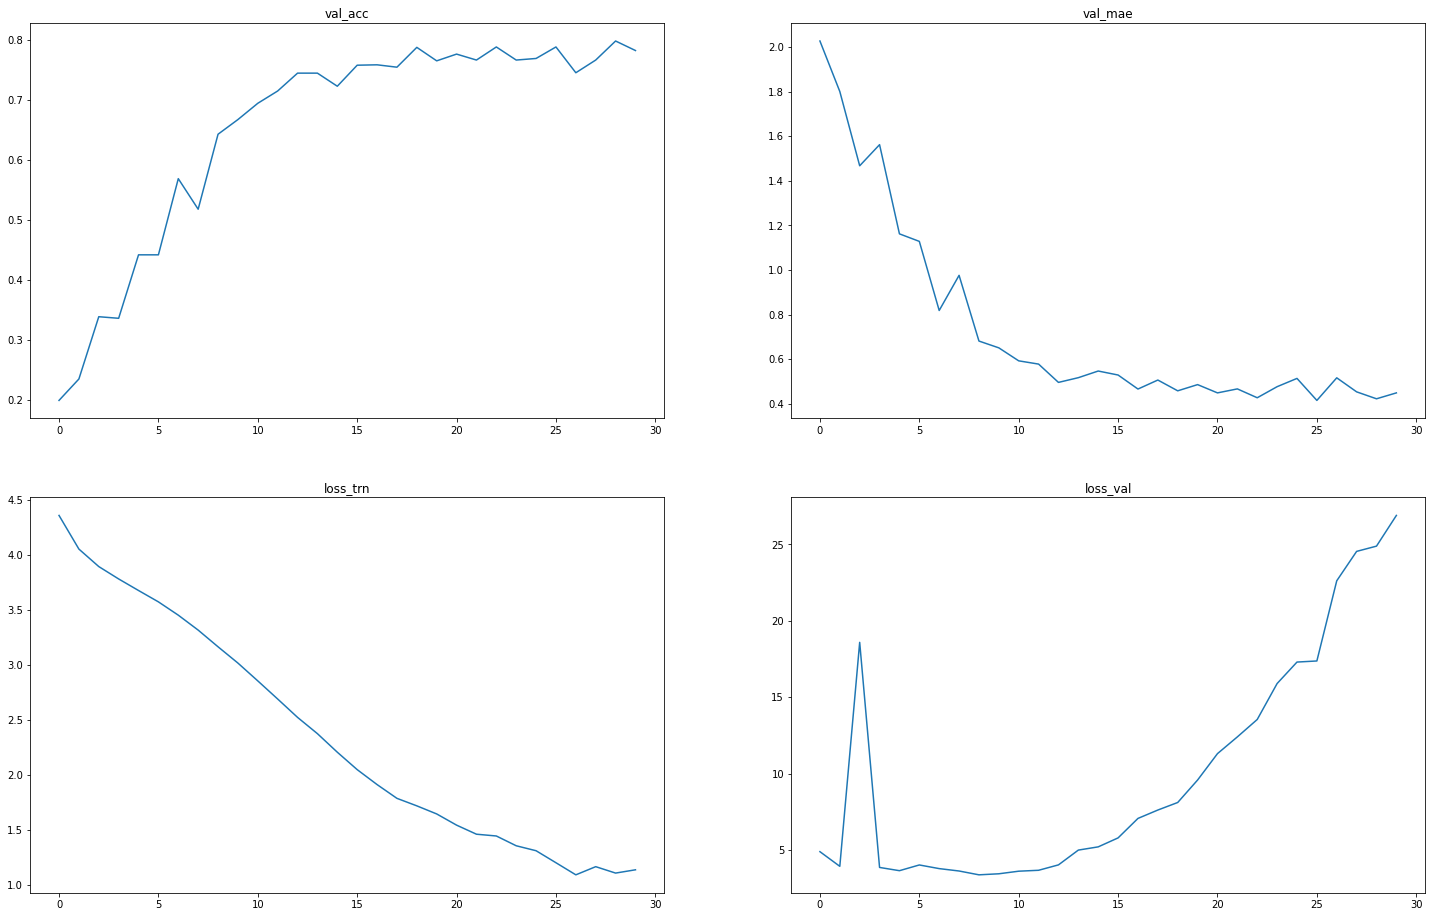

In [ ]:
hist_lbl = ['val_acc', 'val_mae', 'loss_trn', 'loss_val']

plt.figure(figsize=(25, 16))
for n, i in enumerate(hist_mel):
    sp = plt.subplot(221 + n)
    sp.title.set_text(hist_lbl[n])
    plt.plot(i)
plt.show()

In [ ]:
model_eval = model_mel_bestacc
running_corrects = 0
model_eval.eval()
labels = torch.Tensor().to(device)
predicts = torch.Tensor().to(device)
for inputs,lbl in  dataloaders_dict['test']:
    input = inputs.to(device)
    lbl = lbl.to(device)
    with torch.no_grad():
        outputs = model_eval(input)
    _, preds = torch.max(outputs, 1)
    labels = torch.cat((labels, lbl))
    predicts = torch.cat((predicts, preds))
    running_corrects += torch.sum(preds == lbl.data)
acc = running_corrects.double() / len(dataloaders_dict['test'].dataset)
print('Test Acc: {:4f}'.format(acc))

labels = labels.cpu().numpy()
predicts = predicts.cpu().numpy()


pep8(_ih)

Test Acc: 0.771353
cell_content.py:3:18: W291 trailing whitespace
cell_content.py:6:19: E271 multiple spaces after keyword
cell_content.py:6:46: W291 trailing whitespace



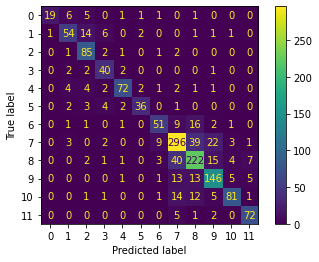

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cfn_matrix = confusion_matrix(labels, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cfn_matrix) 
disp.plot()
plt.show()

In [ ]:
mean_absolute_error(labels, predicts)

0.4165563

In [ ]:
test_acc, test_recall, test_prec, test_f1 = get_perfomance(
    labels,
    predicts)
print("test_acc= {:s}".format(np.array2string(test_acc,
                              precision=2,
                              floatmode='fixed')))
print("test_recall= {:s}".format(np.array2string(test_recall,
                                 precision=2,
                                 floatmode='fixed')))
print("test_precision= {:s}".format(np.array2string(test_prec,
                                    precision=2,
                                    floatmode='fixed')))
print("test_f1= {:s}".format(np.array2string(test_f1,
                             precision=2,
                             floatmode='fixed')))


pep8(_ih)

test_acc= [0.99 0.97 0.97 0.98 0.98 0.99 0.97 0.89 0.90 0.94 0.97 0.99]
test_recall= [0.56 0.67 0.92 0.85 0.81 0.75 0.62 0.79 0.75 0.79 0.70 0.90]
test_precision= [0.95 0.74 0.73 0.69 0.89 0.88 0.75 0.77 0.73 0.75 0.85 0.84]
test_f1= [0.70 0.71 0.81 0.76 0.85 0.81 0.68 0.78 0.74 0.77 0.77 0.87]



Работа MultitaskLoss. Параметры оптимизируются в процессе обучения:


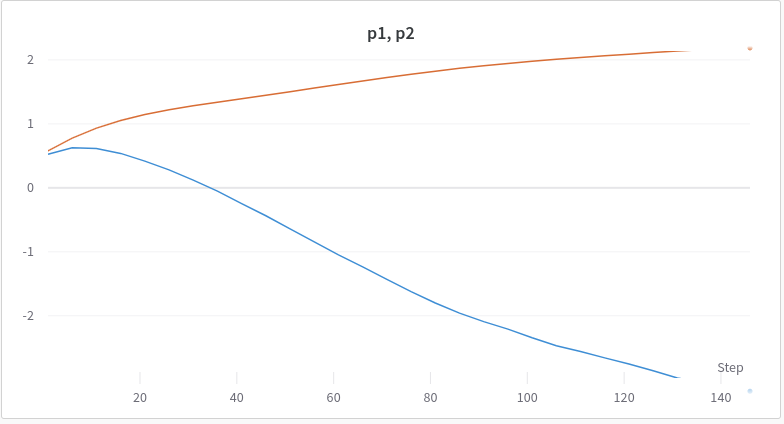

F1-Score в процессе обучения:

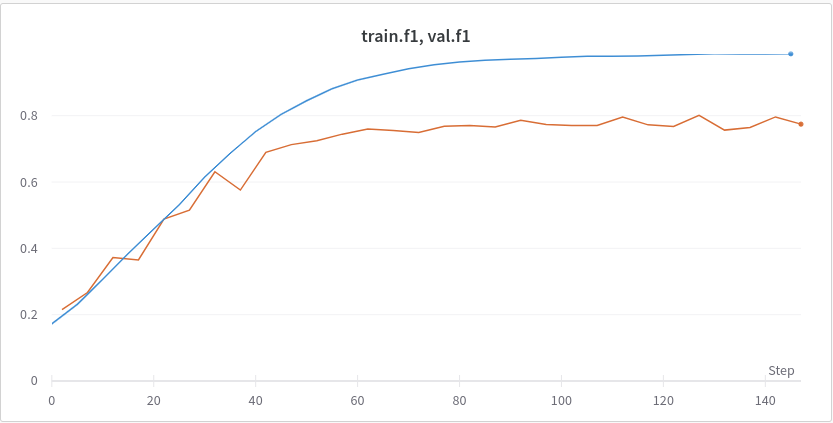